In [1]:
using Plots
using LinearAlgebra
using Random
using Distributions

In [2]:
# Example data
Random.seed!(1234)  # determinism

# controlled-conditioning matrix
function rand_cond_mat(m::Int64, s::Float64)
    A = randn(m, 6)
    A[:, 3] = A[:, 1] + 3 * A[:, 2] + randn(m) / s
    A[:, 6] = A[:, 4] + 5 * A[:, 5] + randn(m) / s
    A = [A ones(m)]
    A ./= maximum(svdvals(A))  # Scale so that || X ||_2 = 1
    return A
end

# Get sample-feature matrices and linear systems
m = 100
scales = 10.0 .^ (1:7)
As = [rand_cond_mat(m, s) for s in scales]
r = 1e-1 * randn(m)
xtrue = randn(size(As[1], 2))
bs = [A * xtrue + r for A in As];

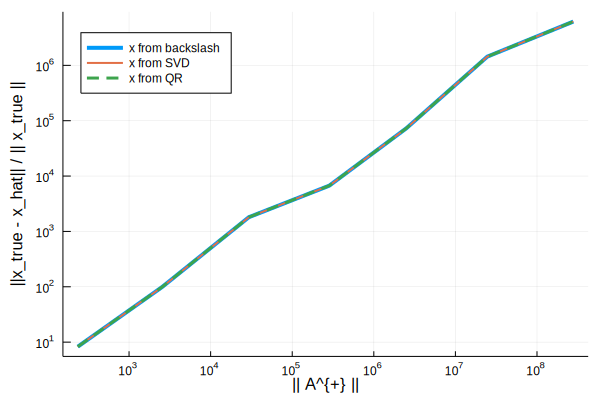

In [3]:
# Linear least squares solvers
ls_bs(A::Array{Float64,2}, b::Vector{Float64}) = A \ b
function ls_qr(A::Array{Float64,2}, b::Vector{Float64})
    Q, R = qr(A)
    return R \ (Matrix(Q)' * b)
end
function ls_svd(A::Array{Float64,2}, b::Vector{Float64})
    U, Σ, V = svd(A)
    return V * (Diagonal(Σ) \ (U' * b))
end

# Solutions
xhat_bs   = [ls_bs(  A, b) for (A, b) in zip(As, bs)]
xhat_qr   = [ls_qr(  A, b) for (A, b) in zip(As, bs)]
xhat_svd  = [ls_svd( A, b) for (A, b) in zip(As, bs)]

# Difference with xtrue
ntrue = norm(xtrue)
bs_diff   = [norm(x - xtrue) / ntrue for x in xhat_bs]
qr_diff   = [norm(x - xtrue) / ntrue for x in xhat_qr]
svd_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd]

conds = [opnorm(pinv(A),2) for A in As]
plot(conds,  bs_diff,   lw=4,
     xlabel="|| A^{+} ||", ylabel="||x_true - x_hat|| / || x_true ||", 
     xscale=:log10, yscale=:log10, 
     label="x from backslash", legend=:topleft)
plot!(conds, svd_diff,  lw=2, label="x from SVD")
plot!(conds, qr_diff,   lw=3, ls=:dash, label="x from QR")

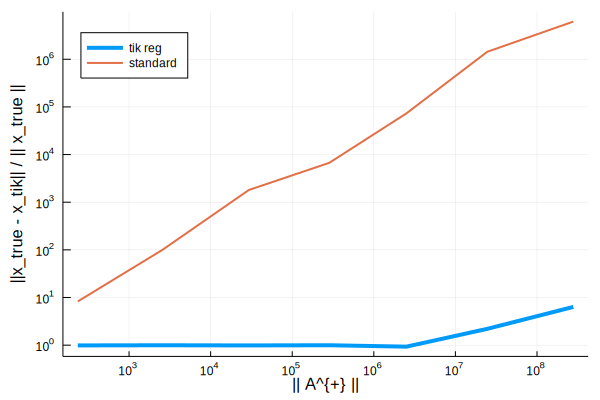

In [4]:
# Tikhonov regularization
function ls_svd_tik(A::Array{Float64,2}, b::Vector{Float64}, λ::Float64)
    U, Σ, V = svd(A)
    FΣ = Σ ./ (Σ .^ 2 .+ λ^2)
    return V * (Diagonal(FΣ) \ (U' * b))
end

λ = 0.001
xhat_svd_tik  = [ls_svd_tik(A, b, λ) for (A, b) in zip(As, bs)]
svd_tik_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd_tik]
plot(conds,  svd_tik_diff,   lw=4,
     xlabel="|| A^{+} ||", ylabel="||x_true - x_tik|| / || x_true ||", 
     xscale=:log10, yscale=:log10, label="tik reg", legend=:topleft)
plot!(conds, svd_diff,  lw=2, label="standard")

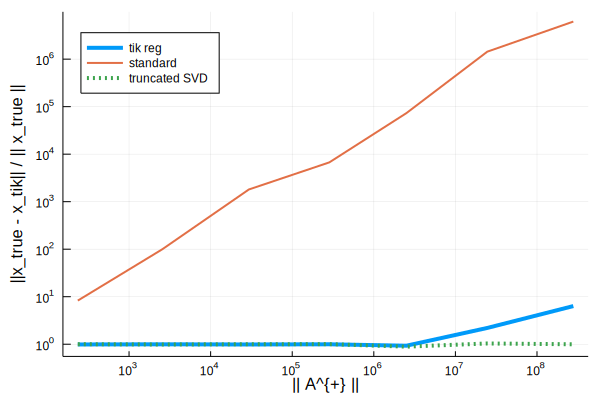

In [5]:
# Truncated SVD
function ls_svd_trunc(A::Array{Float64,2}, b::Vector{Float64}, ϵ::Float64)
    U, Σ, V = svd(A)
    k = findfirst(z -> z < ϵ, Σ)     # find where to threshold
    if   k == nothing k = length(Σ)
    else              k -= 1
    end
    return V[:,1:k] * (Diagonal(Σ[1:k]) \ (U[:,1:k]' * b))
end

ϵ = svdvals(As[1])[4] * (1 + 1e-8)
xhat_svd_trunc  = [ls_svd_trunc(A, b, ϵ) for (A, b) in zip(As, bs)]
svd_trunc_diff  = [norm(x - xtrue) / ntrue for x in xhat_svd_trunc]
plot!(conds, svd_trunc_diff,  lw=4, ls=:dot, label="truncated SVD")

In [6]:
# Pivoted QR (note: R not computed "on the fly"; for demonstration purposes only)
function ls_PQR(A::Array{Float64,2}, b::Vector{Float64}, ϵ::Float64)
    F = qr(A, Val(true))
    k = findfirst(z -> z < ϵ, abs.(diag(F.R)))
    if   k == nothing k = length(F.p)
    else              k -= 1
    end
    Rk = F.R[1:k, 1:k]              # Get k x k matrix R_k
    Qk = F.Q[:, 1:k]                # Get n x k matrix Q_k
    xhat = zeros(size(A, 2))
    xhat[F.p[1:k]] = Rk \ (Qk' * b) # Non-zeros come from solve on reduced system
    return xhat
end

ϵ = 0.00001
for xhat_pqr in [ls_PQR(A, b, ϵ) for (A, b) in zip(As, bs)]
    println(xhat_pqr)
end

[5.51925, 17.0586, -5.21622, -0.272025, -6.76853, 1.3492, 0.075382]
[-34.7293, -104.357, 34.848, 39.9079, 196.426, -39.2304, 0.146227]
[-1290.69, -3872.63, 1290.8, -32.8293, -174.411, 34.7823, -0.26285]
[-0.575223, 0.0, 0.386137, 0.335216, 0.0, 0.10276, 0.448861]
[-0.171222, 0.0, 0.0956683, 1.05496, 0.0, -0.12745, 0.2898]
[0.12982, 0.0, -0.121393, -0.213334, 0.0, -0.00679584, 0.238356]
[0.0442576, 0.0, 0.0196412, 1.38952, 0.0, -0.00623885, 0.179248]


In [7]:
# You can use ScikitLearn in Julia!
using ScikitLearn
@sk_import linear_model : Lasso
@sk_import linear_model : lars_path;

In [8]:
function lasso_solve(A::Array{Float64,2}, b::Vector{Float64}, λ::Float64)
    model = Lasso(alpha=λ,             # amount of regularization
                  fit_intercept=false  # we already have intercepts
                 )
    fit!(model, A, b)  
    return model[:coef_]
end

for xhat_lasso in [lasso_solve(A, b, 0.00001) for (A, b) in zip(As, bs)]
    println(xhat_lasso)
end

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = lasso_solve(::Array{Float64,2}, ::Array{Float64,1}, ::Float64) at In[8]:6
└ @ Main ./In[8]:6


[0.0, 0.588731, 0.275398, 1.04421, -0.0, -0.0107091, 0.0224719]
[0.043703, -0.0, 0.0424702, 0.647073, 0.0, 0.0537966, 0.100035]
[0.0, -0.0, -0.0715882, 1.81559, -0.0, -0.104297, 0.0371628]
[-0.54174, 0.0, 0.379678, 0.317579, 0.0, 0.102489, 0.418377]
[-0.142344, 0.0, 0.0903556, 1.03103, -0.0, -0.124814, 0.263869]
[0.0998885, -0.0, -0.115608, -0.19108, -0.0, -0.00653309, 0.214435]
[0.0187265, -0.0, 0.0211652, 1.35993, -0.0, -0.00345032, 0.151555]


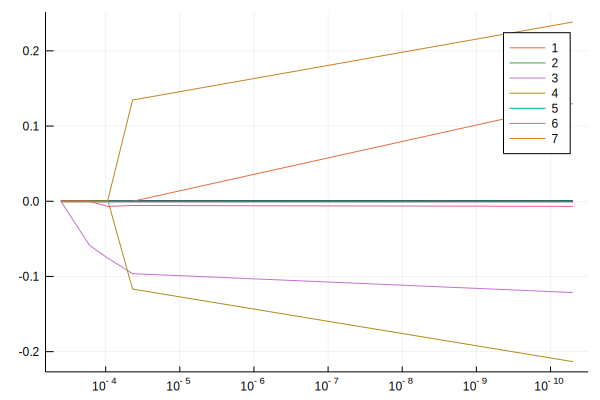

In [9]:
pts, _, all_coeffs = lars_path(As[end-1], bs[end-1], method="lasso")
plot(pts, zeros(length(pts)), lw=2, color="black", xscale=:log10, label="", legend=:topright, xflip = true)
# bug with for loops and plotting (ugh!)
plot!(pts, vec(all_coeffs[1, :]), lw=1, label="1")
plot!(pts, vec(all_coeffs[2, :]), lw=1, label="2")
plot!(pts, vec(all_coeffs[3, :]), lw=1, label="3")
plot!(pts, vec(all_coeffs[4, :]), lw=1, label="4")
plot!(pts, vec(all_coeffs[5, :]), lw=1, label="5")
plot!(pts, vec(all_coeffs[6, :]), lw=1, label="6")
plot!(pts, vec(all_coeffs[7, :]), lw=1, label="7")